In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import xbudget
import regionate
import xwmt
import xwmb
import xgcm
import cartopy.crs as ccrs
import CM4Xutils #needed to run: pip install nc-time-axis
from regionate import MaskRegions, GriddedRegion
import seaborn as sns
import sys
import matplotlib.ticker as mticker

sys.path.insert(0, '/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/src')
from src import *
sns.set_style("darkgrid")

In [3]:
print('xgcm version', xgcm.__version__, '\nregionate version', regionate.__version__, '\nxwmt version', xwmt.__version__, '\nxwmb version', xwmb.__version__)

xgcm version 0.8.2.dev15+g7492277 
regionate version 0.1.1 
xwmt version 0.3.0 
xwmb version 0.2.1


In [4]:
import sectionate
print(f"Sectionate version: {sectionate.__version__}")

Sectionate version: 0.2.1


In [5]:
from Streamfunctions import *
from Streamfunctions_Sectionate import *

rho0 = 1035. # kg/m3
Sv_s_per_m3 = 1e-6
Sv_s_per_kg = Sv_s_per_m3/rho0

In [6]:
def get_transports(ds): 
    ds_subset = ds[["umo", "vmo", "thkcello", "sigma2_i", "areacello", "wet", "wet_u", "wet_v"]]
    return ds_subset

In [7]:
datadir = lambda x="" : "/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/data/" + x
ds = xr.open_mfdataset(
        datadir("model/CM4Xp125_budgets_sigma2_2020-2024.zarr"),
        data_vars="minimal",
        coords="minimal",
        compat="override",
        parallel=True,
        preprocess = get_transports, 
        engine="zarr")

In [8]:
ds = ds.groupby("time.year").mean("time").compute()

In [9]:
%%time
ds_transport_snapshot = ds.isel(year = 0).compute()
lats = np.sort(ds_transport_snapshot.geolat.mean("xh").values)
grid = CM4Xutils.ds_to_grid(ds_transport_snapshot, Zprefix = "sigma2")
moc_indices = generate_moc_grid_indices(grid, lats = lats, parallel = True)

using predefined latitudes


Processing latitudes in parallel (34 workers):  74%|███████▎  | 165/224 [00:42<00:06,  8.57lat/s]/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/sectionate/section.py:517: RuntimeWarning: invalid value encountered in scalar divide
  return np.arccos(np.clip((np.cos(a) - np.cos(b)*np.cos(c))/(np.sin(b)*np.sin(c)), -1., 1.))
Processing latitudes in parallel (34 workers): 100%|██████████| 224/224 [00:55<00:00,  4.03lat/s]

CPU times: user 6min 20s, sys: 19.7 s, total: 6min 40s
Wall time: 55.7 s


In [11]:
%%time 
ds_transport = ds.compute()
grid = CM4Xutils.ds_to_grid(ds_transport, Zprefix = "sigma2")

CPU times: user 772 μs, sys: 0 ns, total: 772 μs
Wall time: 787 μs


In [ ]:
def process_lat_thk(grid, grid_indices, lat):
    # Update grid with time-specific data
    
    # Process each latitude
    lat_results = []

    for lat in latitudes:
        lat_result = thickness_across_latitude(grid, grid_indices[lat], lat, Z_prefix = Z_prefix)
        lat_results.append(lat_result)

    
    # Combine latitude results
    combined = xr.concat(lat_results, dim="lat").sortby("lat")

    return combined

In [26]:
from tqdm import tqdm


In [36]:
%%time
latitude_transports = []
latitude_thk = []

for lat in tqdm(lats, desc="Processing latitudes", unit="lat"):
    latitude_transports+= [transport_across_latitude(grid, moc_indices[lat], lat, 
                                                     Z_prefix = "sigma2", reverse_cumsum = True)]
    latitude_thk += [thickness_across_latitude(grid, moc_indices[lat], lat, Z_prefix = "sigma2")]

moc_all_times = xr.concat(latitude_transports, dim = "lat").rename("conv_mass_transport")
thk_all_times = xr.concat(latitude_thk, dim = "lat").rename("conv_mass_transport")

Processing latitudes:  33%|███▎      | 73/224 [00:14<00:30,  4.95lat/s]

KeyboardInterrupt



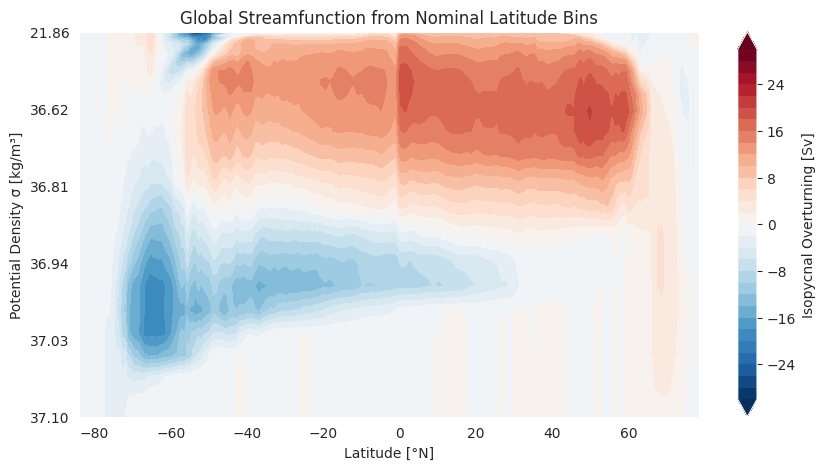

In [24]:
rho0 = 1035. # kg/m3
Sv_s_per_m3 = 1e-6
Sv_s_per_kg = Sv_s_per_m3/rho0

psi_crop = Sv_s_per_kg * moc_all_times.mean("year").sel(sigma2_l = slice(20, 37.1))
# psi_crop = 1e-6 * psi_crop.where(np.abs(psi_crop) > 1).fillna(0.0)

# Create figure
fig, ax = plt.subplots(figsize=(10, 5))

levels = np.arange(-30, 30 +0.1, 2.0)

plot_isopycnal_overturning(fig, ax, 
    psi_crop.isel(exp = 1).T,
    density_dim='sigma2_l',           # Your density dimension name
    lat_dim='lat',                  # Your latitude dimension name
    power = 50,
    levels = levels
)
ax.set_title("Global Streamfunction from Nominal Latitude Bins")
ax.invert_yaxis()

/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/numba/np/ufunc/gufunc.py:252: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)


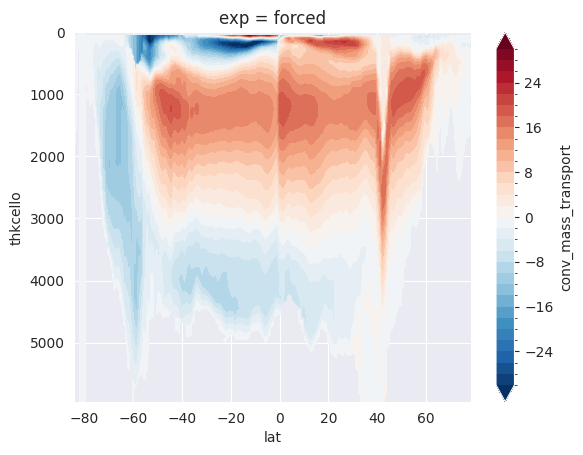

In [40]:
dim = "sigma2"
mean_thickness = moc_time_result["thkcello"].mean("year")

surface_loc = (0.0 * mean_thickness.isel({f"{dim}_l":0}).fillna(0.0))
surface_loc.coords[f"{dim}_l"] = 1000

cell_boundaries = xr.concat([surface_loc, mean_thickness], dim = f"{dim}_l")
cell_boundaries = cell_boundaries.cumsum(dim = f"{dim}_l")

h_np1 = cell_boundaries.isel({f"{dim}_l" : slice(0, -1)}) 
h_n = cell_boundaries.isel({f"{dim}_l" : slice(1, None)}) 
h_np1.coords[f"{dim}_l"] = h_n.coords[f"{dim}_l"]

z_rho = ((h_np1 + h_n) / 2).where(mean_thickness > 0) #midpoint between cell interfaces

sect_grid = Grid(moc_time_result[["conv_mass_transport"]], coords={'Z': {'center': 'sigma2_l'},},
                periodic=False, autoparse_metadata=False)

target_depth_levels = np.arange(0, 6000, 50)
psi_on_z = sect_grid.transform(sect_grid._ds.conv_mass_transport, 'Z', 
                               target_depth_levels, target_data=z_rho, method='linear')

levels = np.arange(-30, 30 + 0.1, 2.0)

fig, ax = plt.subplots()
(psi_on_z.isel(exp = 0)).mean("year").T.plot.contourf(ax = ax, levels = levels, extend = "both")
ax.invert_yaxis()